Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\2939241641.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
119/119 [==============================] - 10s 78ms/step - loss: 0.4969 - accuracy: 0.7456 - val_loss: 0.5039 - val_accuracy: 0.7624
Epoch 2/10
119/119 [==============================] - 10s 83ms/step - loss: 0.2713 - accuracy: 0.8891 - val_loss: 0.2626 - val_accuracy: 0.9092
Epoch 3/10
119/119 [==============================] - 9s 77ms/step - loss: 0.1822 - accuracy: 0.9341 - val_loss: 0.1964 - val_accuracy: 0.9420
Epoch 4/10
119/119 [==============================] - 9s 77ms/step - loss: 0.1270 - accuracy: 0.9568 - val_loss: 0.1474 - val_accuracy: 0.9629
Epoch 5/10
119/119 [==============================] - 9s 75ms/step - loss: 0.0940 - accuracy: 0.9698 - val_loss: 0.0690 - val_accuracy: 0.9848
Epoch 6/10
116/116 [==============================] - 1s 5ms/step
Epoch 1/10
119/119 [==============================] - 9s 77ms/step - loss: 0.5776 - accuracy: 0.7833 - val_loss: 0.3781 - val_accuracy: 0.8373
Epoch 2/10
119/119 [==============================] - 9s 74ms/step - loss:

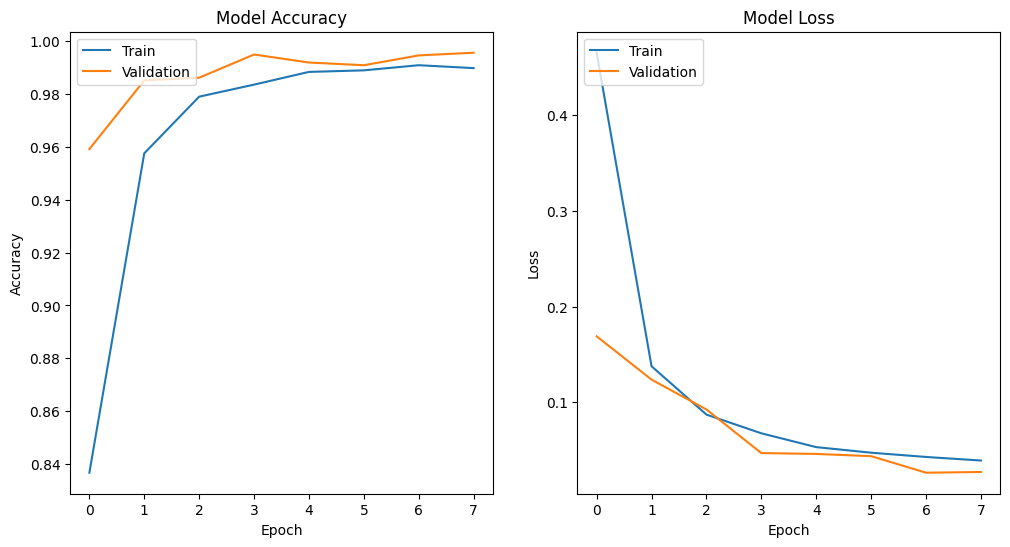

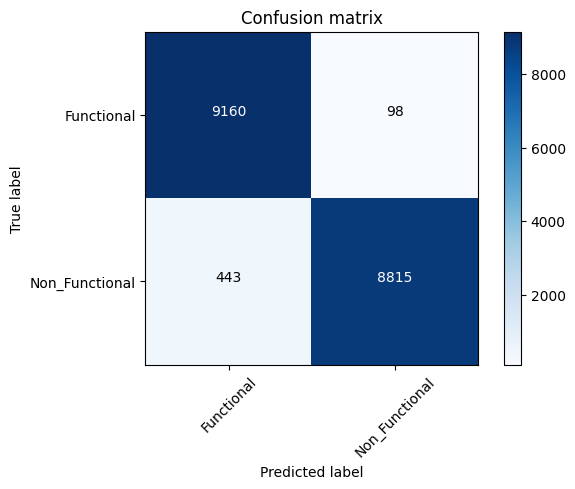

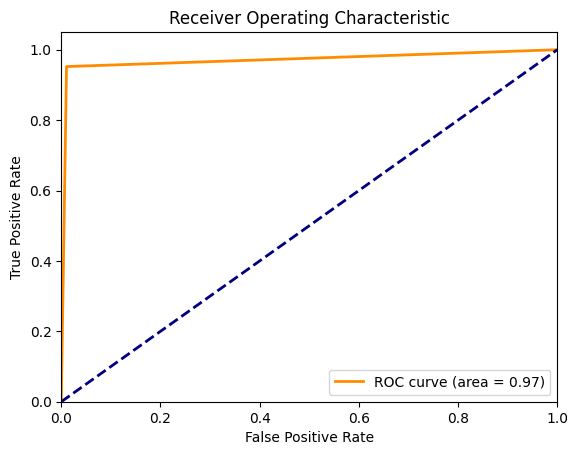

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9258
           1       0.99      0.95      0.97      9258

    accuracy                           0.97     18516
   macro avg       0.97      0.97      0.97     18516
weighted avg       0.97      0.97      0.97     18516



In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150


# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot for model accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot for model loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Save the figure
    plt.savefig('training_and_validation_accuracy.png', dpi=300)
    
    # Display the figure
    plt.show()

plot_history(history)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_cnn.png', dpi=300)  # Corrected indentation
    plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('ROC_cnn.png', dpi=300)  # Corrected indentation
    plt.show()


# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\3588797036.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
10/10 [==============================] - 2s 89ms/step - loss: 0.6786 - accuracy: 0.5886 - val_loss: 0.9072 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 5ms/step
Epoch 1/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6614 - accuracy: 0.6245 - val_loss: 0.9943 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 75ms/step - loss: 0.6449 - accuracy: 0.6245 - val_loss: 0.9590 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 72ms/step - loss: 0.6176 - accuracy: 0.6245 - val_loss: 0.9329 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 71ms/step - loss: 0.5726 - accuracy: 0.6582 - val_loss: 0.8859 - val_accuracy: 0.1603
Epoch 5/10
10/10 [==============================] - 1s 70ms/step - loss: 0.5082 - accuracy: 0.8017 - val_loss: 0.8296 - val_accuracy: 0.4641
Epoch 6/10
10/10 [==============================] - 1s 74ms/step - loss: 0

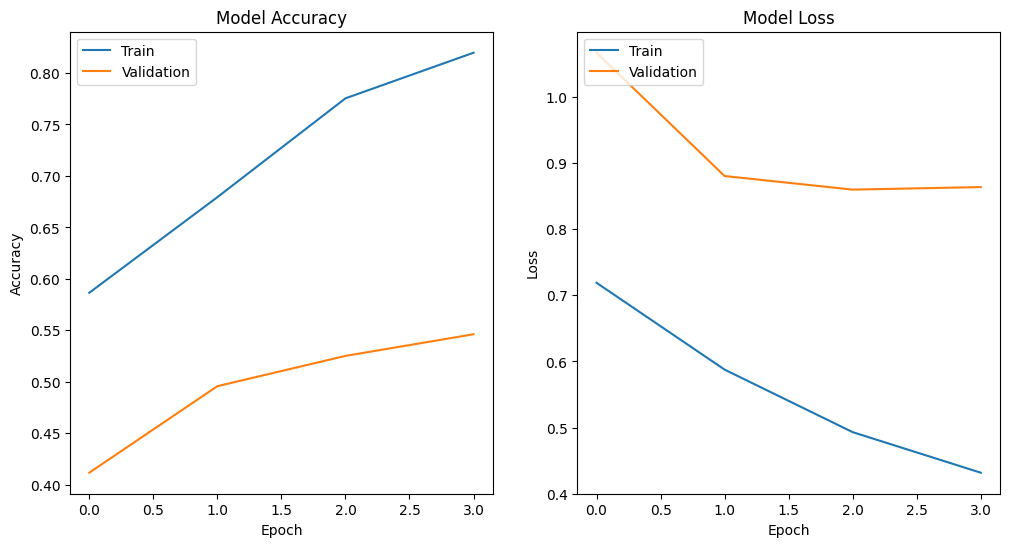

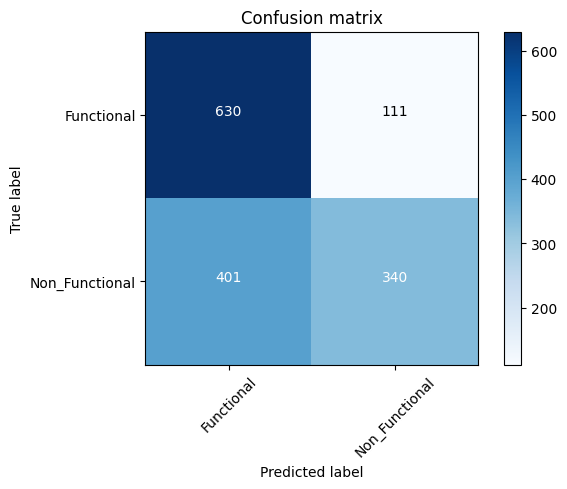

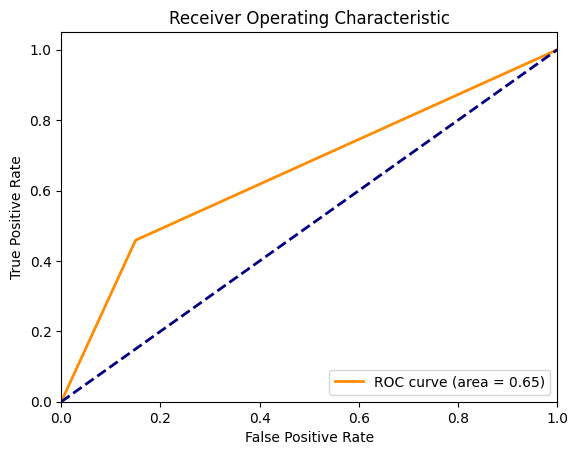

              precision    recall  f1-score   support

           0       0.61      0.85      0.71       741
           1       0.75      0.46      0.57       741

    accuracy                           0.65      1482
   macro avg       0.68      0.65      0.64      1482
weighted avg       0.68      0.65      0.64      1482



In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

#oversampler = RandomOverSampler(random_state=42)
#X_resampled_over, y_resampled_over = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)


# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation

def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    # return history, np.array(all_predictions), np.array(all_actuals)
    return history, np.array(all_predictions), np.array(all_actuals)
# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)
#history_over, all_predictions_over, all_actuals_over, fpr_over, tpr_over = get_dataset_words_frequency_over(X_resampled_over, y_resampled_over, max_words, max_len)
# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\3281728385.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
119/119 [==============================] - 10s 77ms/step - loss: 0.4985 - accuracy: 0.7417 - val_loss: 0.4070 - val_accuracy: 0.8346
Epoch 2/10
119/119 [==============================] - 9s 77ms/step - loss: 0.2712 - accuracy: 0.8909 - val_loss: 0.3149 - val_accuracy: 0.8647
Epoch 3/10
119/119 [==============================] - 9s 78ms/step - loss: 0.1841 - accuracy: 0.9354 - val_loss: 0.1509 - val_accuracy: 0.9615
Epoch 4/10
119/119 [==============================] - 9s 78ms/step - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.1076 - val_accuracy: 0.9744
Epoch 5/10
119/119 [==============================] - 9s 79ms/step - loss: 0.0931 - accuracy: 0.9698 - val_loss: 0.0645 - val_accuracy: 0.9811
Epoch 6/10
119/119 [==============================] - 9s 78ms/step - loss: 0.0703 - accuracy: 0.9772 - val_loss: 0.0559 - val_accuracy: 0.9821
Epoch 7/10
119/119 [==============================] - 9s 78ms/step - loss: 0.0586 - accuracy: 0.9817 - val_loss: 0.0411 - val_accuracy: 0.988

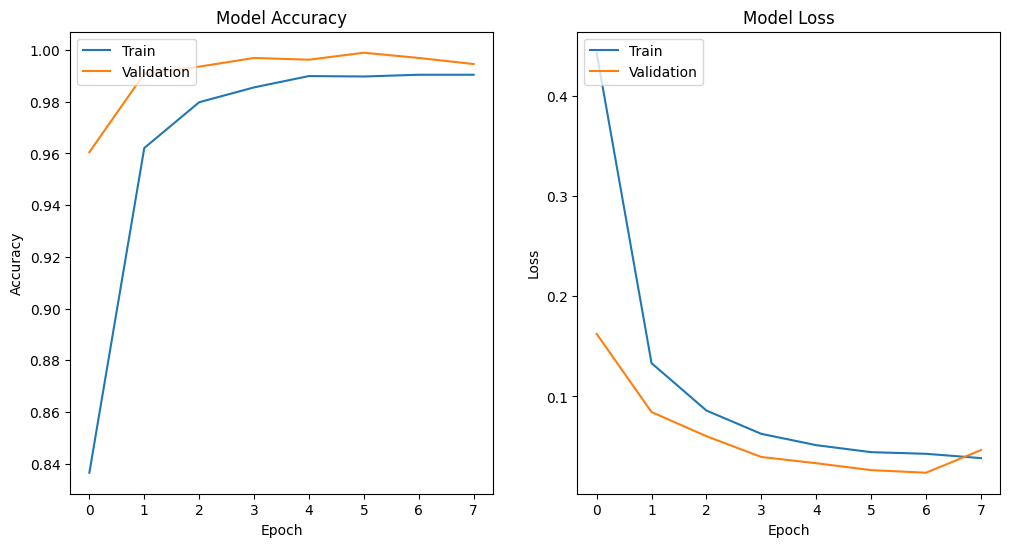

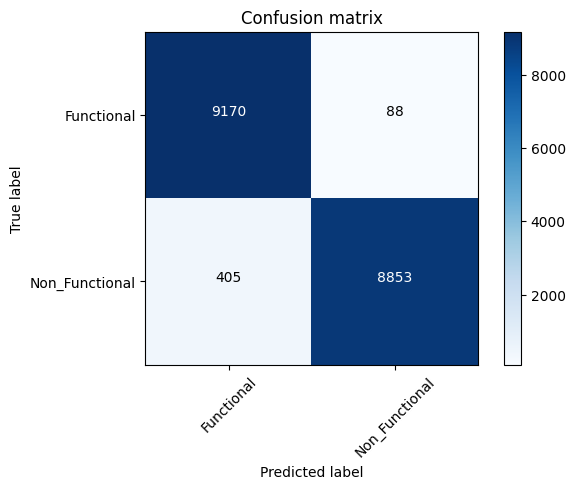

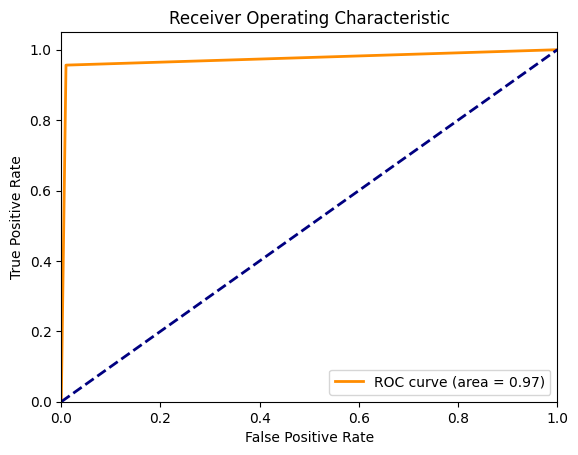

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9258
           1       0.99      0.96      0.97      9258

    accuracy                           0.97     18516
   macro avg       0.97      0.97      0.97     18516
weighted avg       0.97      0.97      0.97     18516



In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150


# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\2249622127.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
10/10 [==============================] - 2s 94ms/step - loss: 0.6882 - accuracy: 0.5179 - val_loss: 0.8560 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 6ms/step
Epoch 1/10
10/10 [==============================] - 1s 84ms/step - loss: 0.6588 - accuracy: 0.6245 - val_loss: 1.0356 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 80ms/step - loss: 0.6417 - accuracy: 0.6245 - val_loss: 0.9272 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 82ms/step - loss: 0.6135 - accuracy: 0.6245 - val_loss: 0.9044 - val_accuracy: 0.0084
Epoch 4/10
10/10 [==============================] - 1s 79ms/step - loss: 0.5675 - accuracy: 0.6614 - val_loss: 0.9035 - val_accuracy: 0.1772
Epoch 5/10
10/10 [==============================] - 1s 94ms/step - loss: 0.5014 - accuracy: 0.7964 - val_loss: 0.8033 - val_accuracy: 0.4895
Epoch 6/10
10/10 [==============================] - 1s 81ms/step - loss: 0.430

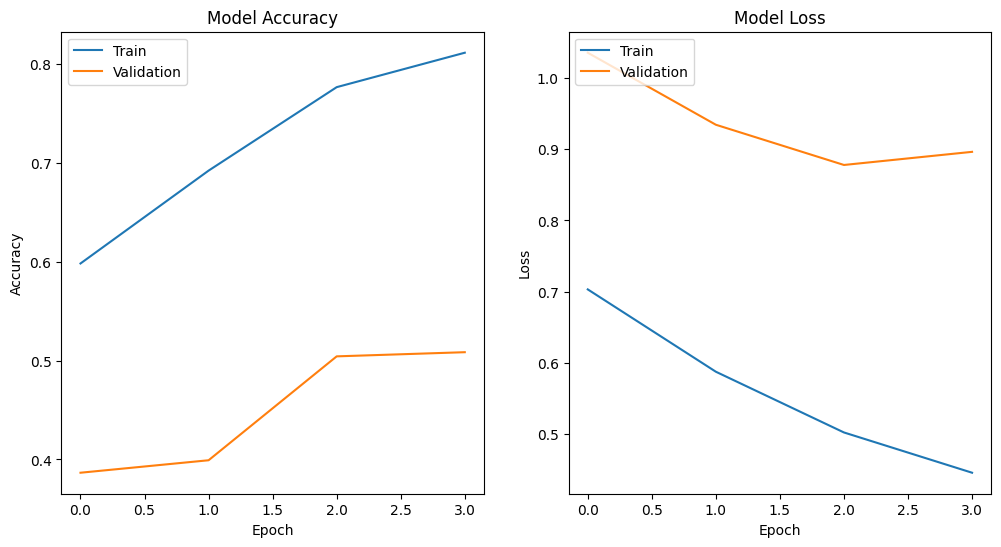

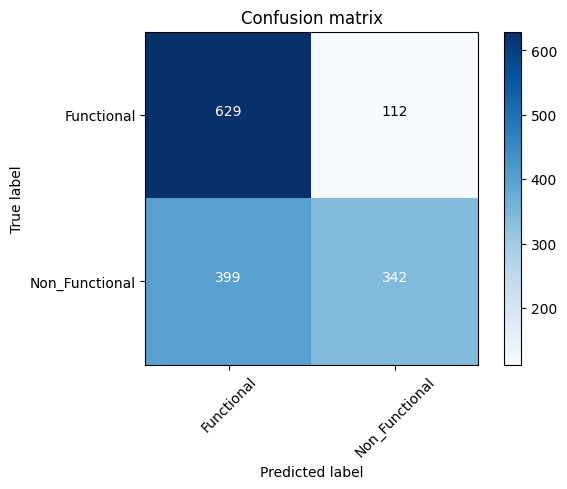

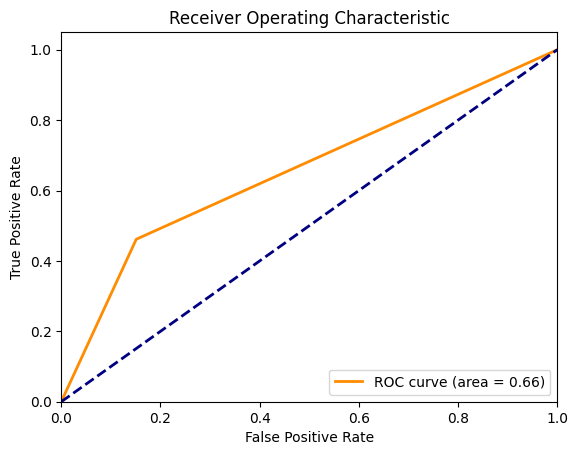

              precision    recall  f1-score   support

           0       0.61      0.85      0.71       741
           1       0.75      0.46      0.57       741

    accuracy                           0.66      1482
   macro avg       0.68      0.66      0.64      1482
weighted avg       0.68      0.66      0.64      1482



In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150



# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\3458617906.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

NLTK data downloaded.
Epoch 1/10
119/119 [==============================] - 10s 79ms/step - loss: 0.4945 - accuracy: 0.7514 - val_loss: 0.3903 - val_accuracy: 0.8397
Epoch 2/10
119/119 [==============================] - 9s 77ms/step - loss: 0.2700 - accuracy: 0.8926 - val_loss: 0.1930 - val_accuracy: 0.9396
Epoch 3/10
116/116 [==============================] - 1s 5ms/step
Epoch 1/10
119/119 [==============================] - 10s 79ms/step - loss: 0.4979 - accuracy: 0.7437 - val_loss: 0.4575 - val_accuracy: 0.7833
Epoch 2/10
119/119 [==============================] - 9s 77ms/step - loss: 0.2674 - accuracy: 0.8936 - val_loss: 0.2883 - val_accuracy: 0.8873
Epoch 3/10
119/119 [==============================] - 9s 77ms/step - loss: 0.1781 - accuracy: 0.9390 - val_loss: 0.2119 - val_accuracy: 0.9359
Epoch 4/10
119/119 [==============================] - 9s 78ms/step - loss: 0.1217 - accuracy: 0.9612 - val_loss: 0.1291 - val_accuracy: 0.9636
Epoch 5/10
119/119 [==============================] 

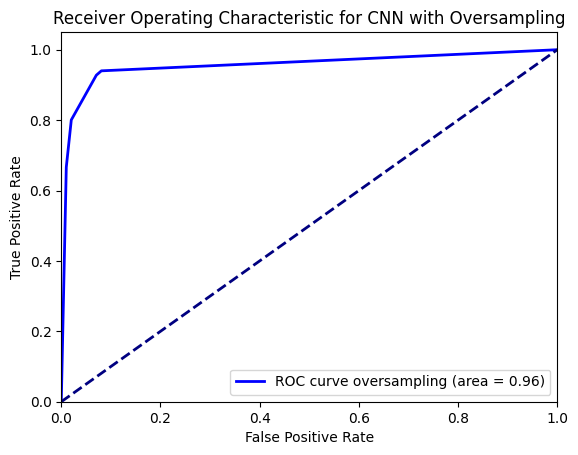

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      9258
           1       0.98      0.94      0.96      9258

    accuracy                           0.96     18516
   macro avg       0.96      0.96      0.96     18516
weighted avg       0.96      0.96      0.96     18516



In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predicted_targets = []
    all_actual_targets = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predicted_targets.extend(predictions)
        all_actual_targets.extend(Test_Y)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc, all_predicted_targets, all_actual_targets

# Get ROC data
mean_fpr_over, mean_tpr_over, mean_auc_over, all_predictions_over, all_actuals_over = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot ROC Curve
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Oversampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for oversampling
print(classification_report(all_actuals_over, all_predictions_over))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_7280\3261658075.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
10/10 [==============================] - 1s 87ms/step - loss: 0.6645 - accuracy: 0.6297 - val_loss: 0.9829 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 4ms/step
Epoch 1/10
10/10 [==============================] - 1s 87ms/step - loss: 0.6781 - accuracy: 0.5738 - val_loss: 0.9131 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 4ms/step
Epoch 1/10
10/10 [==============================] - 1s 90ms/step - loss: 0.6687 - accuracy: 0.6203 - val_loss: 0.9695 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 5ms/step
Epoch 1/10
10/10 [==============================] - 2s 90ms/step - loss: 0.6662 - accuracy: 0.6245 - val_loss: 0.9991 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 77ms/step - loss: 0.6461 - accuracy: 0.6245 - val_loss: 0.9677 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 79ms/step - loss: 0.6231 - a

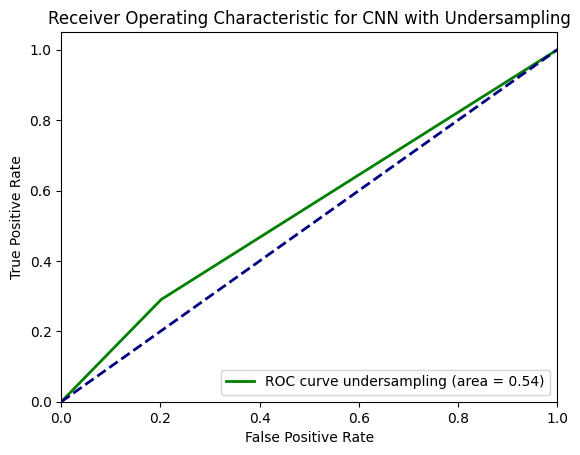

              precision    recall  f1-score   support

           0       0.52      0.96      0.68       741
           1       0.76      0.13      0.22       741

    accuracy                           0.54      1482
   macro avg       0.64      0.54      0.45      1482
weighted avg       0.64      0.54      0.45      1482



In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model_under = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency_under(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score_under = []
    all_predictions_under = []
    all_actuals_under = []
    tprs_under = []
    mean_fpr_under = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs_under.append(np.interp(mean_fpr_under, fpr, tpr))
        tprs_under[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predictions_under.extend(predictions)
        all_actuals_under.extend(Test_Y)

    mean_tpr_under = np.mean(tprs_under, axis=0)
    mean_tpr_under[-1] = 1.0
    mean_auc_under = auc(mean_fpr_under, mean_tpr_under)

    return mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under

# Get ROC data for undersampling
mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under = get_dataset_words_frequency_under(X_resampled_under, y_resampled_under, max_words, max_len)

# Plot ROC Curve for Undersampling
plt.figure()
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Undersampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for undersampling
print(classification_report(all_actuals_under, all_predictions_under))


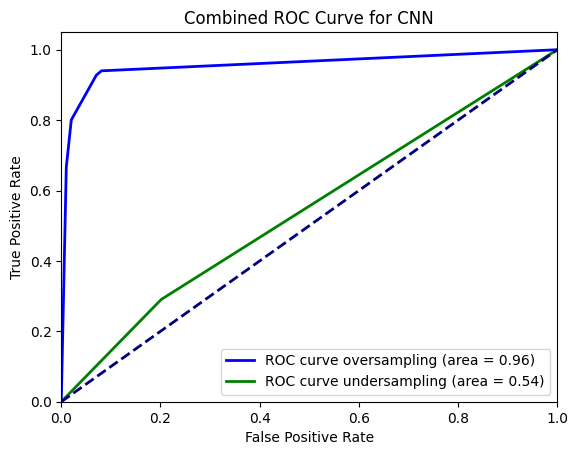

In [10]:
import matplotlib.pyplot as plt

# Make sure to run the oversampling and undersampling code blocks before this to get the ROC data
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the plot
plt.savefig('combined_roc_curve.png', dpi=300)

plt.show()
